<a href="https://colab.research.google.com/github/Xabz/c-/blob/master/Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
import glob
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import time
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
import albumentations as albu

if albu.__version__ != '1.0.3':
    os.system('pip install -U git+https://github.com/albumentations-team/albumentations')
    print('albumentations updated\nrestart required')

#!pip -q install coclust
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
#from coclust.evaluation.external import accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print(albu.__version__)

albumentations updated
restart required
0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists('./CEDAR'):
    ret = os.system("cp '/content/drive/MyDrive/Dataset/CEDAR.zip' '/content/CEDAR.zip'")
    #if ret !=0:
        #ret = os.system("cp '/content/drive/MyDrive/IAM.zip' '/content/IAM Handwritten.zip'")
        #ret = os.system("cp '/content/drive/MyDrive/IAM_line images.zip' '/content/IAM Handwritten_images.zip'")
        #ret = os.system("cp '/content/drive/MyDrive/IAM_line labels.zip' '/content/IAM Handwritten_labels.zip'")
    if ret == 0:  print("Data loaded")
    os.system("unzip -qq '/content/CEDAR.zip'")
    #os.system("unzip -qq '/content/IAM Handwritten_labels.zip'")

Data loaded


In [ ]:
import cv2
import numpy as np
# For image drawing
from PIL import Image, ImageDraw, ImageFont, ImageEnhance

def change_contrast(img, level):
    # Input is a Image type
    # use Image.fromarray() on numpy
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)


def change_sharpness(img, level):
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(level)
    return img


def adjust(img, blevel, slevel, clevel, colevel):
    # brightness
    benhance = ImageEnhance.Brightness(img)
    img = benhance.enhance(blevel)
    # sharpness
    img = change_sharpness(img, slevel)
    # contrast
    img = change_contrast(img, clevel)
    # color
    cenhance = ImageEnhance.Color(img)
    img = cenhance.enhance(colevel)
    return img


def improveImage(img_dir):
    img = cv2.imread(img_dir, -1)
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0,
                                 beta=255, norm_type=cv2.NORM_MINMAX,
                                 dtype=cv2.CV_8UC1)

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm


def convert_image(image_dir):
    img = improveImage(image_dir)
    img = adjust(Image.fromarray(img),
                  blevel=0.7, slevel=1, clevel=255,
                  colevel=1)
    return img

In [ ]:
originals_path = '/content/signatures/full_org/*.png'
forgeries_path = '/content/signatures/full_forg/*.png'

original = []
ground_label = []
faurd = []
faurd_label = []

for idx,filename in enumerate(sorted(glob.glob(originals_path))):
    s_filename = filename.split('/')[-1]
    s_filename = s_filename.split('_')[-2]
    try:
        im = convert_image(filename)#.convert('RGB')
        im = ImageOps.grayscale(im)
        im = ImageOps.invert(im)
        #print(np.asarray(im).shape)
        im.save(filename,format='png')
        original.append(filename)
        ground_label.append(s_filename)
    except:
      continue
#print('finished')
for filename in sorted(glob.glob(forgeries_path)):
    s_filename = filename.split('/')[-1]
    s_filename = s_filename.split('_')[-2]
    try:
        im = convert_image(filename)#.convert('RGB')
        im = ImageOps.grayscale(im)
        im = ImageOps.invert(im)
        #print(np.asarray(im).shape)
        im.save(filename,format='png')
        faurd.append(filename)
        faurd_label.append(s_filename)
    except:
      continue


original = np.asarray(original)
ground_label = np.asarray(ground_label,dtype='int32')
faurd = np.asarray(faurd)
faurd_label = np.asarray(faurd_label,dtype='int32')

ground_label = LabelEncoder().fit_transform(ground_label)
faurd_label = LabelEncoder().fit_transform(faurd_label)

print(original.shape,ground_label.shape,faurd.shape,faurd_label.shape)
print(len(np.unique(original)),len(np.unique(ground_label)),len(np.unique(faurd)),len(np.unique(faurd_label)))

(1320,) (1320,) (1320,) (1320,)
1320 55 1320 55


In [ ]:
ulabels = np.unique(ground_label)
class_index = dict([(label, list(np.where(ground_label == label)[0])) \
                                 for label in ulabels])
flabels = np.unique(faurd_label)
f_class_index = dict([(label, list(np.where(faurd_label == label)[0])) \
                                 for label in flabels])

x = []
gy = []
f = []
fy = []

for i in range(45):
    for j in class_index[i]:
        #print(original[j],ground_label[j])
        x.append(original[j])
        gy.append(ground_label[j])
for i in range(45):
    for j in f_class_index[i]:
        #print(faurd[j],faurd_label[j])
        f.append(faurd[j])
        fy.append(faurd_label[j])

val_x=[]
val_gy = []
val_f = []
val_fy =[]

for i in range(45,55):
    for j in class_index[i]:
        val_x.append(original[j])
        val_gy.append(ground_label[j])
for i in range(45,55):
    for j in f_class_index[i]:
        val_f.append(faurd[j])
        val_fy.append(faurd_label[j])

x  = np.asarray(x)
f = np.asarray(f)
gy = np.asarray(gy)
fy = np.asarray(fy)
val_x  = np.asarray(val_x)
val_f = np.asarray(val_f)
val_gy = np.asarray(val_gy)
val_fy = np.asarray(val_fy)

print(x.shape,gy.shape,f.shape,fy.shape)
print(val_x.shape,val_gy.shape,val_f.shape,val_fy.shape)

(1080,) (1080,) (1080,) (1080,)
(240,) (240,) (240,) (240,)


In [ ]:
class AEGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y
        Performes pairwise matching with a batch size
        both pairs are generated from the input X and y

        imgs         : Input image directory
        y            : Pseudo label, Numpy Array, Output shape=(bs, ) or (bs, 1)
        gt           : Ground truth of the actual class, Numpy Array, Output shape=(bs, ) or (bs, 1).
        dist      : Distance parameter for AE
        noise     : Ratio of augmentation
        scale     : The maximum limit of noise that would be mixed with X
        show_logs : Show random selection errors

                    Use only when show_logs is True

        dg = AEGenerator(iX=X, iy=cy, dist=dist, noise=noise,
                         batch_size=batch_size, scale=aug_scale,
                         show_logs=False, gt=y,
                         output_channel=1 if model == 'MobileNet' else 3)

    """

    def __init__(self, original, dist, ground_label, faurd, faurd_label,
                 input_shape, batch_size=64, show_logs=False, prob=1.0, validation=False):

        self.batch_size  = batch_size
        self.x = original
        self.gy = ground_label
        self.f = faurd
        self.fy = faurd_label

        # Probability of augmentation
        self.prob = prob

        if self.gy.shape[-1] == 1:
            self.gy = np.squeeze(self.gy)
        if self.fy.shape[-1] == 1:
            self.fy = np.squeeze(self.fy)

        assert len(input_shape) == 3, 'Input shape must be 3 dimentional'
        self.input_shape = input_shape

        self.total = len(self.x)
        self.f_total = len(self.f)
        self.dist = dist

        # Generates label : indexes_where_label_found
        ulabels = np.unique(self.gy)
        self.class_index = dict([(label, list(np.where(self.gy == label)[0])) \
                                 for label in ulabels])
        flabels=np.unique(self.fy)
        self.f_class_index = dict([(label, list(np.where(self.fy == label)[0])) \
                                 for label in flabels])

        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size
        self.classes = len(ulabels)

        self.rand = random.Random(12)
        random.seed(12)

        # Show logs
        self.show_logs = show_logs
        self.validation = validation
        self.log = {}
        self.on_epoch_end()
        self.aug_func = AEGenerator.strong_aug(self.input_shape, p=self.prob)


    # Strong augmentation features
    @staticmethod
    def strong_aug(img_shape, p=0.6):
        # horizontal
        hh = int(img_shape[0]*0.8)
        hw = int(img_shape[1]*0.08)
        # vertical
        vh = int(img_shape[0]*0.04)
        vw = int(img_shape[1]*0.8)
        return albu.Compose([
            # albu.RandomSizedCrop((img_shape[0]-int(img_shape[0]*0.8),
            #                          img_shape[0]+int(img_shape[0]*0.8)),
            #                          img_shape[0], img_shape[1],
            #                          (img_shape[1]-int(img_shape[1](0.4)),
            #                          img_shape[1]),
            #                       p=0.5),
            # albu.OneOf([
            #     albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.25, rotate_limit=24,p=0.17),
            #     # albu.CenterCrop(height=40,width=50,p=0.17),
            #     albu.RandomSizedCrop(min_max_height=(img_shape[0]-50,img_shape[0]),height=img_shape[0],width=img_shape[1],p=0.17),
            # ], p=0.5),
            # albu.OneOf([
            #     albu.ElasticTransform(interpolation=0,border_mode=0,p=0.1),
            #     albu.OpticalDistortion(interpolation=0,border_mode=0,p=0.1),
            #     albu.GridDistortion(p=0.1),
            # ], p=0.5),

            # albu.Cutout(num_holes=4, max_h_size=2, max_w_size=4,p=0.5),

            # # albu.OneOf([
            #     albu.RandomRain(slant_lower=-10, slant_upper=10,brightness_coefficient=1.0,blur_value=2, p=0.25),
            #     albu.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.04,p=0.15),

            # ], p=0.5),
            # albu.OneOf([
            #     albu.augmentations.transforms.Downscale(p=0.17),
            #     albu.ImageCompression(p=0.17),
            # ], p=0.5),
            albu.ShiftScaleRotate(shift_limit=0, scale_limit=[-0.6, 0.6],
                                              rotate_limit=45, p=0.5),
            # albu.OneOf([
            #     # albu.IAAEmboss(p=0.17),
            #     # albu.IAASharpen(p=0.17),
            #     # albu.OpticalDistortion(p=0.17),
            #     # albu.GridDistortion(p=0.17),
            #     # albu.IAAPiecewiseAffine(p=0.17),
            #     # albu.RandomRain(brightness_coefficient=1, drop_width=1,
            #     #            blur_value=1, p=0.17),
            #     # Erosion(p=0.5),
            #     # Dilate(p=0.5),
            # ], p=1),
            albu.Flip(p=1)
        ], p=p)



    @staticmethod
    def image_resize(image, width = None, height = None):
        """Img is a PIL image"""
        dim = (113,80)
        #(w, h) = image.size

        # if width is None and height is None:
        #     dim = (113,80)
        # if width is None:
        #     r = height / float(h)
        #     dim = (int(w * r), height)
        # else:
        #     r = width / float(w)
        #     dim = (width, int(h * r))
        return image.resize(dim)


    def __len__(self):
        """ Denotes the number of batches per epoch """
        return self.total_batch


    def _print_logs(self):
        for a, b in self.log.items():
            print(a, ':', b)


    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.indexes)
        if self.show_logs:
            self._print_logs()
            self.log['canNotLink_error'] = 0
            self.log['time'] = 0


    def _make_choice(self, p=None):
        w = [0.5, 0.5]
        if p is not None:
            w = [p, 1-p]
        return self.rand.choices([True, False], weights=w)[0]


    def read_image(self, image_id):
        """Reads an image from disk, given image_id
            Randomly crops the image w.r.t. input_shape
        """
        im = Image.open(self.x[image_id])
        # Resize the image w.r.t. aspect ratio
        im = AEGenerator.image_resize(im)
        im = np.asarray(im, dtype=np.uint8)
        #print(im.shape)

        # if self.validation:
        #     val_im = self.line_image_mean(im)
        #     return val_im

        #w_pos_l = np.random.randint(low=0, high=max(im.shape[1]-self.input_shape[1]-1, 1))
        return im#[..., w_pos_l:w_pos_l+self.input_shape[1],:]


    def _augment(self, imgs):
        """ Inputs some image indices,
            Returns the augmented images
            Input_dim : [2*batch_size, ]
        """
        aug_imgs = np.zeros((len(imgs), ) + self.input_shape, dtype=np.uint8)

        # print('Imgs:', imgs.shape)
        for i in range(len(imgs)):
            aug_imgs[i] = self.aug_func(image=imgs[i])['image']
            # print('Augmented')
            # plt.imshow(aug_imgs[i], cmap='gray')
            # plt.show()

        return aug_imgs

    def __getitem__(self, index):
        """ Generate one batch of data """
        idx = np.zeros((2, self.batch_size), dtype=np.int16)
        idx[0] = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        constraint = np.zeros((self.batch_size,1), dtype=np.float16)

        if self.validation == False:
            imgs = np.zeros((2*self.batch_size, self.input_shape[0],self.input_shape[1]), dtype=np.uint8)
            for i in range(self.batch_size):
                plabel = self.gy[idx[0][i]]
                take = idx[0][i]
                # print(plabel)
                # print(take)
                # Generating must-links
                if self._make_choice():
                    # print("true")

                    idx[1][i] = self.rand.choice(self.class_index[plabel])

                    tmp_img1 = self.read_image(idx[0][i])
                    tmp_img2 = self.read_image(idx[1][i])
                    #print(np.asarray(tmp_img1).shape)
                    imgs[i] = tmp_img1
                    imgs[i+self.batch_size] = tmp_img2

                else:
                    # print('False')
                    # Taking random pair
                    # if self._make_choice():
                    #     while self.fy[idx[1][i]] != plabel:
                    #         idx[1][i] = self.rand.choice(self.f_class_index[plabel])
                    # else:
                    #     while self.fy[idx[1][i]] == plabel:
                    #           idx[1][i] = self.rand.choice(self.indexes)

                    while self.fy[idx[1][i]] != plabel:
                        idx[1][i] = self.rand.choice(self.f_class_index[plabel])

                    tmp_img1 = self.read_image(idx[0][i])
                        #tmp_img2 = self.read_image(self.f[idx[1][i]])
                    im = Image.open(self.f[idx[1][i]])
                        # Resize the image w.r.t. aspect ratio
                    im = AEGenerator.image_resize(im, height=self.input_shape[0])
                    im = np.asarray(im, dtype=np.uint8)
                        # w_pos_l = np.random.randint(low=0, high=max(im.shape[1]-self.input_shape[1]-1, 1))
                    tmp_img2 = im#[..., w_pos_l:w_pos_l+self.input_shape[1],:]
                    imgs[i] = tmp_img1
                    imgs[i+self.batch_size] = tmp_img2
                    constraint[i] = self.dist


            if self.prob > 0:
                aug_idx = self.rand.sample(range(2*self.batch_size), k=self.batch_size-16)
                imgs[aug_idx] = self._augment(imgs[aug_idx])
            imgs = imgs[...,np.newaxis]

            return [imgs[:self.batch_size], imgs[self.batch_size:]], constraint

        else:
            imgs = np.zeros((self.batch_size, self.input_shape[0], self.input_shape[1]), dtype=np.uint8)
            constraint = np.zeros(self.batch_size, dtype=np.int16)
            for i in range(self.batch_size):
                tmp_img = self.read_image(idx[0][i])
                imgs[i] = tmp_img
                constraint[i] = self.gy[idx[0][i]]
            imgs = imgs[...,np.newaxis]

            return imgs,constraint



    # def __getitem__(self, batch_index):
    #     """ Generate one batch of data """
    #     idx, y = self._genIndexes(batch_index)
    #     #img_dirs = self.x[idx]

    #     # Reading the image files
    #     if self.validation==False:
    #         imgs = np.ones((2*self.batch_size, ) + self.input_shape, dtype=np.uint8)
    #         #print(imgs.shape,self.input_shape)
    #         for i in range(2*self.batch_size):
    #             tmp_img = self.read_image(idx[i])
    #             #print("get_item:",tmp_img.shape)
    #             #print(tmp_img.shape, imgs[i].shape)
    #             imgs[i, 0:, 0:tmp_img.shape[1], :] = tmp_img[:,:input_shape[1],:]
    #             plt.imshow(imgs[i], cmap='gray')
    #             plt.show()

    #         if self.prob > 0:
    #             aug_idx = self.rand.sample(range(2*self.batch_size), k=self.batch_size)
    #             imgs[aug_idx] = self._augment(imgs[aug_idx])


    #         return [imgs[:self.batch_size], imgs[self.batch_size:]], y

    #     else:
    #         imgs = np.ones((self.batch_size, ) + self.input_shape, dtype=np.uint8)
    #         for i in range(self.batch_size):
    #             tmp_img = self.read_image(idx[i])
    #             #print(tmp_img.shape, imgs[i].shape)
    #             imgs[i, 0:, 0:tmp_img.shape[1], :] = tmp_img
    #             # print(imgs[i].shape)
    #             # plt.imshow(imgs[i], cmap='gray')
    #             # plt.show()
    #             # plt.show()

    #         return imgs, y


    # def _genIndexes(self, index):
    #     idx = np.zeros((2, self.batch_size), dtype=np.int32)
    #     idx[0] = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    #     constraint = np.zeros(self.batch_size, dtype=np.int32)

    #     if self.validation == False:

    #         for i in range(self.batch_size):
    #             plabel = self.gy[idx[0][i]]
    #             take = idx[0][i]

    #             # Generating must-links
    #             if self._make_choice():
    #                 take = self.rand.choice(self.class_index[plabel])
    #             # Generating can-not links
    #             else:
    #                 # Taking random pair
    #                 while self.fy[take] == plabel:
    #                     take = self.rand.choice(self.f_class_index[plabel])
    #                 constraint[i] = self.dist

    #                 if self.show_logs and self.gy[idx[0][i]] == self.gy[take]:
    #                     self.log['canNotLink_error'] += 1

    #             idx[1][i] = take

    #         return idx.reshape((2*self.batch_size)), constraint

    #     else:
    #         for i in range(self.batch_size):
    #             constraint[i]=self.gy[idx[0][i]]
    #         return idx[0],constraint

In [ ]:
input_shape = (80,113,1)
un_dg = AEGenerator(original=val_x, dist=10, ground_label=val_gy,
                     faurd=val_f, faurd_label=val_fy,input_shape=input_shape, batch_size=32,prob=0, validation=False)
xx,yy = un_dg[0]
#print(xx[0].shape,xx[1].shape)

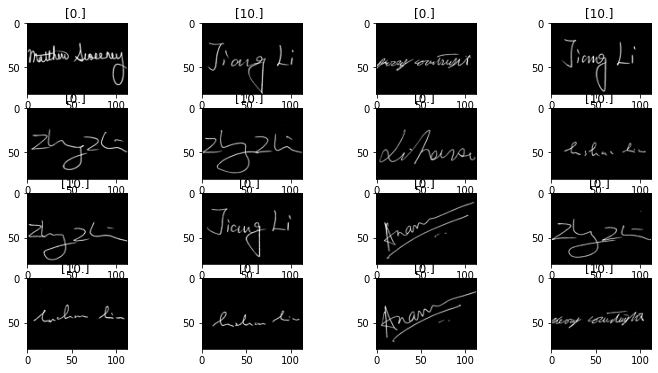

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(12, 6))
for i in range(16):
    ax[i//4, i%4].imshow(xx[0][i, :, :,0], cmap="gray")
    ax[i//4 ,i%4].set_title(f"{yy[i]} ", )


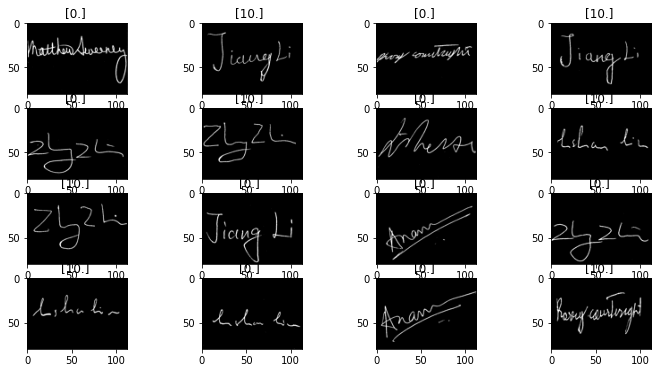

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(12, 6))
for i in range(16):
    ax[i//4, i%4].imshow(xx[1][i, :, :,0], cmap="gray")
    ax[i//4 ,i%4].set_title(f"{yy[i]} " )

(32, 80, 113, 1)


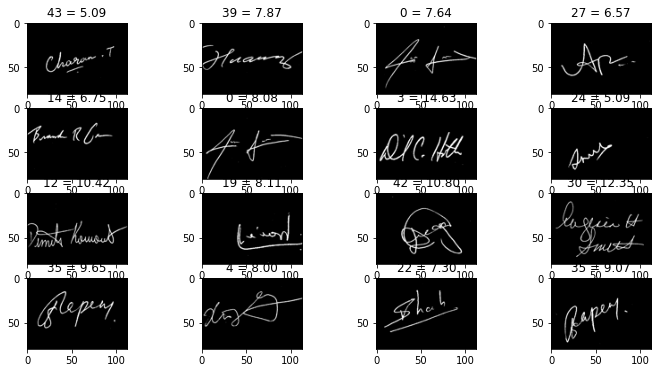

In [ ]:
input_shape = (80,113,1)
un_dg = AEGenerator(original=x, dist=1, ground_label=gy,
                     faurd=f, faurd_label=fy,input_shape=input_shape, batch_size=32,prob=0, validation=True)
xx,yy = un_dg[0]
print(xx.shape)
_, ax = plt.subplots(4, 4, figsize=(12, 6))
for i in range(16):
    ax[i//4, i%4].imshow(xx[i, :, :,0], cmap="gray")
    ax[i//4 ,i%4].set_title(f"{yy[i]} = {xx[i, :, :,0].mean():.2f}" )

In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def accuracy(true_row_labels, predicted_row_labels):
    """Get the best accuracy.
    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model
    Returns
    -------
    float
        Best value of accuracy
    """
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    rows, columns = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(rows, columns):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))


class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=1, validation_data=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data is not None:
            self.x_val, self.y_val = validation_data
            self.classes = len(np.unique(self.y_val))
        self.start_time = time.time()
        self.epoch = 0
        self.savelog = {'Epoch': [], 'ACC':[], 'NMI':[], 'ARI':[]}


    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.n is not 0: return
        self.epoch += 1

        acc, nmi, ari = self._KmeansAcc()
        ep_time = time.time() - self.start_time
        self.start_time = time.time()
        print(f"\rEpoch {self.epoch}: NMI {nmi:.5f} ACC {acc:.5f} ARI {ari:.5f} Time:{ep_time:.1f}",
              end='\n')
        self._saveLog(self.epoch, acc, nmi, ari)


    def _saveLog(self, epoch, acc, nmi, ari):
        self.savelog['Epoch'].append(epoch)
        self.savelog['ACC'].append(acc)
        self.savelog['NMI'].append(nmi)
        self.savelog['ARI'].append(ari)


    def _KmeansAcc(self):
        kmeans = KMeans(n_clusters=self.classes, n_jobs=-1, n_init=10)
        AE = self.model.layers[2]
        rindex = np.random.randint(0, self.y_val.shape[0], size=100)
        outs = AE.predict(self.x_val[rindex])
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(self.y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(self.y_val[rindex], y_pred)
        ari = adjusted_rand_score(self.y_val[rindex], y_pred)
        return (acc, nmi, ari)

In [ ]:
class SaveLog(tf.keras.callbacks.Callback):
    '''
        save_path:     Destination where the model weights are saved.

        save_weights:  True ensures only the wights are saved. Setting to False
                       saves the model weights and network definitions.

        save_on_epoch: Integer declaring the number of epoches after the model
                       is saved.
                        -1: saved if maximum accuracy is found
                        0 : saved on every epoch
                        n > 0: saved after n epochs

        load_prev_model:     If True, the callback loads the previous model weights

        load_prev_log:     If True, the callback loads the previous model logs

        monitor:       On which metric the logger should depend on

        patience:      Number of epochs with no improvement after which
                       training will be stopped.

        mode:          One of `{"auto", "min", "max"}`. In `min` mode,
                       training will stop when the quantity monitored has
                       stopped decreasing; in `"max"` mode it will stop when
                       the quantity monitored has stopped increasing;
                       in `"auto"` mode, the direction is automatically
                       inferred from the name of the monitored quantity.

        save_best_model: If true, the logger saves a different copy of the model
                         with the best value of the monitored quantity.

        restore_best_weights:  Whether to restore model weights from the epoch
                               with the best value of the monitored quantity.
                               If False, the model weights obtained at the last
                               step of training are used.
    '''

    def __init__(self, save_path='./log/',
                 save_on_epoch=-1, monitor='loss', mode='auto',
                 load_prev_model=True, load_prev_log=True,
                 patience=5, save_best_model=True,
                 restore_best_weights=True,
                 verbose=True):

        self.os  = __import__('os')
        self.pkl = __import__('pickle')
        self.np = __import__('numpy')
        self.tf = __import__('tensorflow')
        self.tf.get_logger().setLevel('ERROR')
        super(SaveLog, self).__init__()

        self.save_on_epoch = save_on_epoch
        if save_on_epoch < -2:
            raise ValueError("Invalid 'save_on_epoch' value."
                             " Should be greater than -1.")

        self.monitor = monitor
        self.save_dir = None
        self.log_dir = None
        self.save_best_model = save_best_model
        self.patience = patience
        self.patience_kept = 0
        self.logs = {}
        self.load_prev_model = load_prev_model
        self.load_prev_log = load_prev_log
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path

        if mode == 'min':
            self.monitor_op = self.np.less
            self.metric_val = self.np.inf
            self.mode = 'min'
        elif mode == 'max':
            self.monitor_op = self.np.greater
            self.metric_val = -self.np.inf
            self.mode = 'max'
        else:
            if 'acc' in self.monitor:
                self.monitor_op = self.np.greater
                self.metric_val = -self.np.inf
                self.mode = 'max'
            else:
                self.monitor_op = self.np.less
                self.metric_val = self.np.inf
                self.mode = 'min'


    def _save_model(self, best=False):
        sdir = self.best_dir if best else self.save_dir
        if best:
            self.model.save_weights(sdir)
        else:
            self.model.save(sdir, overwrite=True)
        #if self.verbose:
        print(f'{"Best m" if best else "M"}odel saved on {sdir}')


    def _load_model(self):
        try:
            self.model.load_weights(self.best_dir)
            if self.verbose: print('Previous best weights loaded')
            return
        except:
            pass
        try:
            cnt = 0
            temp_model = self.tf.keras.models.load_model(self.save_dir)
            for i, layer in enumerate(temp_model.layers):
                try:
                    self.model.get_layer(layer.name).set_weights(layer.get_weights())
                    cnt += 1
                except:
                    continue
            if self.verbose: print(f"{cnt} layer weights loaded")
        except:
            pass
        print("Could not load model weights")


    def _save_logs(self, epoch):
        with open(self.log_dir, 'wb') as f:
            self.pkl.dump(self.logs, f)
        if self.verbose: print(f'Logs saved on epoch {epoch+1}')


    def _load_logs(self):
        try:
            with open(self.log_dir, 'rb') as f:
                log = self.pkl.load(f)
            if self.mode == 'max':
                self.metric_val = max(log[self.monitor])
            else:
                self.metric_val = min(log[self.monitor])
            if self.verbose: print(f'Logs loaded, best {self.monitor}: {self.metric_val:.5f}')
            return log
        except:
            return {}


    def _saver(self, epoch, logs):
        log_val = logs[self.monitor]
        if self.save_on_epoch == 0:
            self._save_logs(epoch)
            self._save_model()

            if self.save_best_model and self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                self._save_model(best=True)

        elif self.save_on_epoch == -1:
            if self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                if self.verbose: print('Minimum loss found')
                self._save_logs(epoch)
                if self.save_best_model:
                    self._save_model(best=True)

        elif self.save_on_epoch > 0:
            if epoch % self.save_on_epoch == 0:
                self._save_logs(epoch)
                self._save_model()

        # Weight is always saved!
        if self.save_best_model and self.monitor_op(log_val, self.metric_val):
            self._save_logs(epoch)
            self.metric_val = log_val
            self._save_model(best=True)


    def on_train_begin(self, logs=None):
        self.save_dir = self.os.path.join(self.save_path, self.model.name, '')
        self.best_dir = self.os.path.join(self.save_dir, 'best_weight.h5')
        self.log_dir = self.os.path.join(self.save_dir, 'train_log.pkl')

        new_created = False
        if self.verbose: print('SavePath', self.save_dir)
        if not self.os.path.exists(self.save_dir):
            self.os.makedirs(self.save_dir)
            new_created = True
            if self.verbose: print('New directory created')

        if self.load_prev_model:
            self._load_model()

        if self.load_prev_log:
            self.logs = self._load_logs() or {}


    def on_epoch_end(self, epoch, logs=None):
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)

        if self.patience != None:
            if self.monitor_op(logs[self.monitor], self.metric_val):
                self.patience_kept = 0
            else:
                self.patience_kept += 1
            if self.patience_kept > self.patience:
                self.model.stop_training = True
                if self.verbose: print("Stopping training")
                if self.restore_best_weights:
                    if self.verbose: print("Restoring best weights")
                    self.model.load_weights(self.best_dir)

        self._saver(epoch, logs)

In [ ]:
# class Custom_loss(tf.keras.layers.Layer):
#       def __init__(self,**kwargs):
#           super(Custom_loss,self).__init__(**kwargs)
#           self.dis_entropy = tf.keras.losses.MeanSquaredError()
#           #self.adaptive_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
#           self.writer_acc = tf.keras.metrics.Accuracy(name='writer_acc')
#           self.adaptive_acc = tf.keras.metrics.Accuracy(name='adaptive_acc')

#       def _mean_square(y_true,y_pred):
#           return K.mean(K.reduce_sum(K.square(y_true-y_pred)))
#       def contrastive_los(y_true,y_pred):
#           margin =1
#           for idx,i in enumerate(y_pred):
#             tf.print(i,y-true[idx],end=' ')
#           tf.print('',end='\n')
#           return K.mean((1-y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin-y_pred,0)))
#       def call(self, inputs):
#           #print(np.array(inputs).shape)
#           # Input order: writer pred, adaptive pred, Y_true (from data generator)

#           # print(np.asarray(inputs).shape)
#           relu_pred = inputs[0]
#           sig_pred = inputs[1]
#           dis_true = inputs[2][:]
#           y_true = inputs[2]/10

#           print(dis_true.shape)
#           print(relu_pred.shape)
#           print(y_true.shape)
#           print(sig_pred.shape)


#           dis_loss = self.dis_entropy(dis_true,relu_pred)
#           writer_loss = self.contrastive_los(y_true,sig_pred)
#           self.add_loss(writer_loss)
#           self.add_loss(adaptive_loss)

#           writer_accuracy = self.writer_acc(dis_true, K.argmax(relu_pred, axis=-1))
#           adaptive_accuracy = self.adaptive_acc(y_true, K.argmax(sig_pred, axis=-1))
#           # writer_accuracy = self.writer_acc(w_true, w_pred)
#           # adaptive_accuracy = self.adaptive_acc(a_true, a_pred)
#           self.add_metric(writer_accuracy,"w_acc")
#           self.add_metric(adaptive_accuracy,"a_acc")
#           #return writer_loss * 0.7 + adaptive_loss * 0.3


# def contrastive_los(y_true,y_pred):
#           margin =1
#           for idx,i in enumerate(y_pred):
#             tf.print(i,y-true[idx],end=' ')
#           tf.print('',end='\n')
#           return K.mean((1-y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin-y_pred,0)))

# def custom_loss(y_true, y_pred):
#     # y_true order: writer_identity, word, word_size
#     dist_entropy = tf.keras.losses.MeanSquaredError()


#     dist_loss = dist_entropy(y_true, y_pred)
#     tf.print(y_true[:5])
#     tf.print(y_pred[:5])
#     true = y_true/10
#     pred = y_pred/10
#     def contrastive_loss(y_true, y_pred):
#         """Calculates the constrastive loss.

#       Arguments:
#           y_true: List of labels, each label is of type float32.
#           y_pred: List of predictions of same length as of y_true,
#                   each label is of type float32.

#       Returns:
#           A tensor containing constrastive loss as floating point value.
#       """
#         margin = 1
#         square_pred = tf.math.square(y_pred)
#         margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
#         return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
#     ver_loss = contrastive_loss(true,pred)
#     return dist_loss + ver_loss*10
# writer_acc = tf.keras.metrics.Accuracy()
# def custom_acc(y_true, y_pred):
#     # tf.print(y_true.shape)
#     # tf.print(y_true/10)
#     # tf.print(y_pred/10)
#     a = writer_acc(y_true/10, y_pred/10)
#     return a

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [64, 128, 256] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tf.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x
def middle_flow(x, num_blocks=3) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        # x = Activation('relu')(x)
        # x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tf.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(512, 1, strides=2, padding='same')(previous_block_activation)
    x = tf.keras.layers.Add()([x, residual])

    x = SeparableConv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #x = GlobalAveragePooling2D()(x)
    return x
def create_xception(input_shape,dims):
    inputs = Input(shape=input_shape)
    outputs = exit_flow(middle_flow(entry_flow(inputs)))
    #outputs = Dense(dims)(outputs)
    xception = tf.keras.Model(inputs, outputs)
    return xception


In [ ]:
class Distance(tf.keras.layers.Layer):
    def __init__(self, alpha=1, *args, **kwargs):
        self.alpha = alpha
        super().__init__(*args, **kwargs)
        self.activation = tf.keras.layers.ReLU(max_value=self.alpha)
        #self.activation = tf.keras.layers.Dense(1,activation='sigmoid')

    def call(self, inputs):
        dist = tf.expand_dims(tf.math.sqrt(tf.math.reduce_sum(tf.math.square(inputs[0]-inputs[1]),
                                                              axis=1)),
                              axis=-1)
        return self.activation(dist)

    def get_config(self):
        return {"alpha": self.alpha}

def create_layer(input_shape,dims):
    inp = tf.keras.Input(input_shape)

    #out = tf.keras.layers.Lambda(lambda x: (x/255.0))(inp)

    model = create_xception(input_shape,dims)
    out = model(inp)
    model.summary()
    out = Flatten()(out)
    out = Dense(units=dims)(out)

    model = tf.keras.Model(inp, out, name='AE_Xception')
    model.summary()

    return model

def create_siamese(input_shape,dims,alpha, maml=True, weight_sharing=True):
    input1 = tf.keras.Input(input_shape)
    input2 = tf.keras.Input(input_shape)

    if weight_sharing:
        block = create_layer(input_shape, dims)
        out1 = block(input1)
        out2 = block(input2)
    else:
        out1 = create_layer(input_shape, dims)(input1)
        out2 = create_layer(input_shape, dims)(input2)

    out = Distance(alpha)([out1, out2])
    out = tf.keras.layers.Dense(1,activation='sigmoid')(out)
    # out_sigmoid = Lambda(lambda x: 1/(1+K.exp(-x)))(out_relu)
    # out = Custom_loss()([out_relu,out_sigmoid,true_output])
    if maml:
        print('MAML loading')
        model = MAML([input1,input2], out)
        model.create_temp()
    else:
        model = tf.keras.Model([input1,input2], out, name = 'Small_Xception' )#name=f"{block.name}x{dims}")
    model.compile(optimizer=tf.keras.optimizers.Adam( ),loss=loss(margin=1),metrics=['Accuracy'])
    #model.compile(optimizer=tf.keras.optimizers.Adam( ),loss=custom_loss,metrics=[custom_acc])
    return model

K.clear_session()

dims = 12
input_shape = (80,113,1)
alpha = 10

model = create_siamese(input_shape,dims,alpha, maml=False,
                              weight_sharing=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 80, 113, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 57, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 57, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 40, 57, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
un_dg = AEGenerator(original=x, dist=alpha, ground_label=gy,
                     faurd=f, faurd_label=fy,input_shape=input_shape, batch_size=32,prob=0, validation=False)

log_dg = AEGenerator(original=x, dist=alpha, ground_label=gy,
                     faurd=f, faurd_label=fy,input_shape=input_shape, batch_size=32,prob=0, validation=True)

val_dg = AEGenerator(original=val_x, dist=alpha, ground_label=val_gy,
                     faurd=val_f, faurd_label=val_fy,input_shape=input_shape, batch_size=32,prob=0, validation=False)

In [ ]:
x_val,y_val = log_dg[0]
for i in range(1,30):
    xx,yy = log_dg[i]
    print(xx.shape,i)
    x_val = np.concatenate((x_val,xx),axis=0)
    y_val = np.concatenate((y_val,yy),axis=0)

print(x_val.shape,y_val.shape)

(32, 80, 113, 1) 1
(32, 80, 113, 1) 2
(32, 80, 113, 1) 3
(32, 80, 113, 1) 4
(32, 80, 113, 1) 5
(32, 80, 113, 1) 6
(32, 80, 113, 1) 7
(32, 80, 113, 1) 8
(32, 80, 113, 1) 9
(32, 80, 113, 1) 10
(32, 80, 113, 1) 11
(32, 80, 113, 1) 12
(32, 80, 113, 1) 13
(32, 80, 113, 1) 14
(32, 80, 113, 1) 15
(32, 80, 113, 1) 16
(32, 80, 113, 1) 17
(32, 80, 113, 1) 18
(32, 80, 113, 1) 19
(32, 80, 113, 1) 20
(32, 80, 113, 1) 21
(32, 80, 113, 1) 22
(32, 80, 113, 1) 23
(32, 80, 113, 1) 24
(32, 80, 113, 1) 25
(32, 80, 113, 1) 26
(32, 80, 113, 1) 27
(32, 80, 113, 1) 28
(32, 80, 113, 1) 29
(960, 80, 113, 1) (960,)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1, patience=400,
                                                 verbose=1,
                                                 min_lr=0.1e-7)

log = MyLogger(validation_data=(x_val,y_val))

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=60,
                                              verbose=1, mode="min",
                                              restore_best_weights=False)

logger = SaveLog(save_path=f'/content/drive/MyDrive/signature/',
                 monitor='val_loss',
                 # AutoSave full model + logs after 100 epoches
                 save_on_epoch=100,
                 patience=10000,
                 verbose=True,
                 # Only set this true when you want to reload the previous
                 # weights/logs before training
                 load_prev_model=False,
                 load_prev_log=False,
                 restore_best_weights=False)

In [ ]:
K.set_value(model.optimizer.learning_rate, 1e-4)
"""
val_dg = 2 random image patches for 2 input layers
log = mean of the full line image into a single image patch for K_mean's acc nmi ari
"""

history = model.fit(un_dg, validation_data=val_dg,
                    epochs=500, callbacks=[log,], #logger, reduce_lr],
                    max_queue_size=5, verbose=2, initial_epoch=0)

Epoch 1/500
33/33 - 8s - loss: 2.3656 - Accuracy: 0.0000e+00 - val_loss: 2.4997 - val_Accuracy: 0.5045
Epoch 2: NMI 0.73844 ACC 0.42000 ARI 0.05775 Time:70.2
Epoch 2/500
33/33 - 8s - loss: 2.2425 - Accuracy: 0.0000e+00 - val_loss: 2.5006 - val_Accuracy: 0.4643
Epoch 3: NMI 0.70048 ACC 0.39000 ARI 0.02731 Time:7.9
Epoch 3/500
33/33 - 7s - loss: 2.1513 - Accuracy: 0.0000e+00 - val_loss: 2.4990 - val_Accuracy: 0.4911
Epoch 4: NMI 0.73483 ACC 0.42000 ARI 0.06111 Time:7.9
Epoch 4/500
33/33 - 8s - loss: 2.1259 - Accuracy: 0.0000e+00 - val_loss: 2.4965 - val_Accuracy: 0.4866
Epoch 5: NMI 0.72528 ACC 0.39000 ARI 0.03043 Time:7.9
Epoch 5/500
33/33 - 8s - loss: 2.0527 - Accuracy: 0.0000e+00 - val_loss: 2.4941 - val_Accuracy: 0.3616
Epoch 6: NMI 0.74806 ACC 0.41000 ARI 0.07745 Time:8.0
Epoch 6/500
33/33 - 8s - loss: 1.9134 - Accuracy: 0.0000e+00 - val_loss: 2.4864 - val_Accuracy: 0.1205
Epoch 7: NMI 0.79308 ACC 0.51000 ARI 0.19934 Time:7.9
Epoch 7/500
33/33 - 8s - loss: 1.9587 - Accuracy: 0.0000e

KeyboardInterrupt: ignored

dict_keys(['Epoch', 'ACC', 'NMI', 'ARI'])


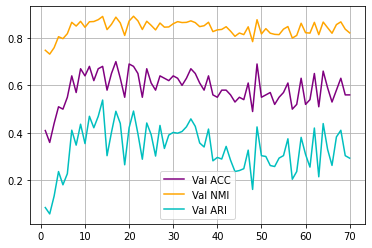

In [ ]:
r from scipy.signal import savgol_filter
import copy

def tplotter(savelog, avg_val=1, epoch_limit=None):
    def moving_average(x, w):
        return savgol_filter(x, w, 1)
        #return np.convolve(x, np.ones(w), 'same') / w
        #return np.convolve(x, np.ones(w), 'valid') / w
    if avg_val > 1:
        for k in savelog.keys():
            if len(savelog[k]) > 0 and k != "Epoch":
                savelog[k] = moving_average(savelog[k], avg_val)

    if epoch_limit != None:
        end_idx = 0
        while end_idx < len(savelog["Epoch"]) and \
              savelog["Epoch"][end_idx] <= epoch_limit:
            end_idx += 1

        for k in savelog.keys():
            if len(savelog[k]) > 0:
                savelog[k] = savelog[k][:end_idx]

    # dashes are the train data
    totLen = len(savelog['ACC'])
    savelog['Epoch'] = savelog['Epoch'][:totLen]

    print(savelog.keys())
    if 'ACC' in savelog.keys():
        plt.plot(savelog['Epoch'], savelog['ACC'], #'--',
                label='Val ACC', c='purple')
        plt.plot(savelog['Epoch'], savelog['NMI'], #'--',
                label='Val NMI', c='orange')
        plt.plot(savelog['Epoch'], savelog['ARI'], #'--',
                label='Val ARI', c='c')

    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/UWriter/{model.name}_4500epoch_freezing_before_spp_w{avg_val}.pdf', dpi=300)

tmp_log = copy.deepcopy(log.savelog)
tplotter(tmp_log, 1)#Frezz 1000epoch

In [ ]:
def plotImgMap(x, y, points,AE, imgsize=(40, 40), figsize=(15, 15), rand=12,
               imgplot=True, legend=False):
    def getImage(img):
        #img = ((img+1)/2)*255
        img = np.array(img, dtype=np.uint8)
        #print(type(img), img.shape, img.dtype)
        img = Image.fromarray(img)
        img = img.resize(imgsize)
        img = img.convert("RGBA")
        ImageDraw.floodfill(img, xy=(0, 0), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(imgsize[0], 0), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(0, imgsize[1]), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(imgsize[0], imgsize[1]), value=(255, 255, 255, 0), thresh=100)
        return OffsetImage(img)

    rnd = random.Random(rand)
    q = np.unique(rnd.sample(range(0, x.shape[0]), points))
    outs = AE(x[q, ...])
    labels = y[q, ...]

    X_embedded = TSNE(n_components=2, random_state=rand).fit_transform(outs)
    fig, ax = plt.subplots(figsize=figsize)

    #if not imgplot:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)

    if imgplot:
        for i, idx in enumerate(q):
            ab = AnnotationBbox(getImage(x[idx]), (X_embedded[i, 0], X_embedded[i, 1]),
                                frameon=False)
            ax.add_artist(ab)
            #c = plt.Circle((X_embedded[i, 0], X_embedded[i, 1]), 3, color='r',
            #               fill=False, clip_on=False)
            #ax.add_patch(c)

    ax.grid(False)
    ax.legend()
    plt.show()

plotImgMap(x_val, y_val, 240, AE=model.layers[2])

In [ ]:
plotImgMap(x_val, y_val, 800, AE=model.layers[2], imgplot=False)

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
import tensorflow as tf
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input =tf.keras.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(10, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x)


input_1 = tf.keras.Input((28, 28, 1))
input_2 = tf.keras.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
print(normal_layer.shape)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

(None, 1)
